# Naive-Bayes (NB)

Naive-Bayes is a supervised method of data classification which aims to use Bayesian reasoning to determine which class a data-point most likely belongs to, given its characteristics. It uses the Bayes equation to determine the conditional probability that a data-point $d_j$ with properties $x_1, x_2,...,x_n$ is in class $C_i$ using the equation $$P(C_i|d_j)=\frac{P(C_i)\times{}P(x_1,x_2,...,x_n|C_i)}{P(x_1,x_2,...,x_n)}$$

A Naive-Bayes classifier uses this formula to calculate $P(C_i|d_j)$ across all classes in the data-set, and assigns data-point $d_j$ to the class $C_i$ for which $P(C_i|d_j)$ is the greatest. The reason this algorithm is *naive* is that it assumes that each of the properties $x_n$ are independent and are not correlated with each other probabalistically. In reality, these properties are often correlated with one another, but nevertheless Naive-Bayes is effective and efficient at classification.

In the case of text mining, the properties $x_n$ used by the Naive-Bayes algorithm can be either the presence/absense of terms (in so-called Bernoulli Naive-Bayes) or term frequencies (multinomial Naive-Bayes). Naive-Bayes is one of the most time-efficient supervised classifiers, but other classifiers like SVM often out-perform it when classifying text data.

### The Procedure

For this project, I'll be using Naive-Bayes and a few other classification methods to attempt to classify the Ground-News dataset along some pre-existing categories: *bias*, *factuality*, and *owner type*. Each of these labels were categories given to the data by Ground News when I scraped it.

**Bias** represents the political slant of the news organization which wrote the news article. It consists of seven categories:

```
    {'Far Left','Left','Lean Left','Center','Lean Right','Right','Far Right'}
```

**Factuality** describes the article's level of factual accuracy. It consists of three categories:

```
    {'High Factuality', 'Mixed Factuality','Low Factuality'}
```

**Owner Type** denotes the type of organization which produced the article. It consists of seven categories:


```
    {'Corporation', 'Government', 'Independent', 'Individual', 'Media Conglomerate', 'Private Equity', 'Other'}
```
```,
    

In [1]:
#Imports
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd
import re
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [5]:
#Data
corpus= pd.read_csv("../data/groundnews_corpus_cleaned.csv",index_col=0)
corpus.head()

,title,summary,bias,factuality,owner,source,owner_type,source_text,title_s,summary_s,source_text_s
0,Greece legalises sex marriage,Greece ha become the first Christian Orthodox ...,Center,High Factuality,Government of the United Kingdom,https://www.bbc.co.uk/news/world-europe-683101...,Government,legalises same sex marriagePublished1 day agoS...,greec legalis sex marriag,greec ha becom the first christian orthodox ma...,legalis same sex marriagepublished1 day agosha...
1,Greece becomes first Orthodox Christian countr...,Lawmakers in the 300 seat parliament voted for...,Lean Left,Mixed Factuality,Scott Trust Limited,https://www.theguardian.com/world/2024/feb/15/...,Independent,becomes first Christian Orthodox country to le...,greec becom first orthodox christian countri l...,lawmak in the 300 seat parliament vote for the...,becom first christian orthodox countri to lega...
2,Greece legalises sex marriage landmark change,The law give same sex couple the right to wed ...,Lean Left,High Factuality,The Hindu Group,https://www.thehindu.com/news/international/gr...,Independent,Greece legalises same sex marriage in landmark...,greec legalis sex marriag landmark chang,the law give same sex coupl the right to wed a...,greec legalis same sex marriag in landmark cha...
3,Greece becomes first Orthodox Christian countr...,Greece ha become the first Orthodox Christian ...,Center,High Factuality,Bell Media,https://www.ctvnews.ca/world/greece-becomes-fi...,Media Conglomerate,Greece becomes first Orthodox Christian countr...,greec becom first orthodox christian countri l...,greec ha becom the first orthodox christian co...,greec becom first orthodox christian countri t...
4,Greece legalises sex marriage another Orthod...,Greece ha become the first majority Orthodox C...,Lean Left,Mixed Factuality,Evgeny Lebedev,https://www.independent.co.uk/news/world/europ...,Individual,Jump to contentUS EditionChangeUK EditionAsia...,greec legalis sex marriag anoth orthodox chr...,greec ha becom the first major orthodox christ...,jump to contentu editionchangeuk editionasia ...


## Raw Data

For this dataset, I'll be creating new WDMs from the dataset using both count-vectorizer and tfidf vectorizer for classification. This will help to determine which of the two methods of vectorization are better for classification.

In [138]:
#Making Vectorizers
MyVect=CountVectorizer(input='content',
                        stop_words='english',
                        token_pattern='(?u)[a-zA-Z]+',
                        lowercase = True
                        )

MyVect_TFIDF=TfidfVectorizer(input='content',
                        analyzer = 'word',
                        stop_words='english',
                        lowercase = True,
                        #binary=True
                        )

In [139]:
#Converting the Ground News Data into a WDM
def create_wdm(corpus,index,cv):
    df = pd.DataFrame(cv.fit_transform(corpus[index]).toarray(),columns=cv.get_feature_names_out())
    return df.filter(regex='(?u)[a-zA-Z]{3}+')
count_wdm = create_wdm(corpus,'title_s',MyVect)
tfidf_wdm = create_wdm(corpus,'title_s',MyVect_TFIDF)
wdms=[count_wdm,tfidf_wdm]
bias={'Far Left':-3,'Left':-2,'Lean Left':-1,'Center':0,'Lean Right':1,'Right':2,'Far Right':3}
factuality={'Low Factuality':0,'Mixed Factuality':1,'High Factuality':2}
owner_type={'Other':-1,'Corporation':0,'Government':1,'Independent':2,'Individual':3,'Media Conglomerate':4,'Private Equity':5}
for wdm in wdms:
    wdm['bias']=corpus['bias'].map(bias).fillna(0)
    wdm['factuality']=corpus['factuality'].map(factuality).fillna(-1)
    wdm['owner_type']=corpus['owner_type'].map(owner_type).fillna(1)

In [140]:
#Creating Training and Testing Datasets.
rd.seed(1234)
TrainCount, TestCount = train_test_split(count_wdm, test_size=0.3)
TrainTFIDF, TestTFIDF = train_test_split(tfidf_wdm, test_size=0.3)

TrainCountLabels=TrainCount[['bias','owner_type','factuality']]
TrainTFIDFLabels=TrainTFIDF[['bias','owner_type','factuality']]
TestCountLabels=TestCount[['bias','owner_type','factuality']]
TestTFIDFLabels=TestTFIDF[['bias','owner_type','factuality']]

TrainCount=TrainCount.drop(['bias','owner_type','factuality'],axis=1)
TrainTFIDF=TrainTFIDF.drop(['bias','owner_type','factuality'],axis=1)
TestCount=TestCount.drop(['bias','owner_type','factuality'],axis=1)
TestTFIDF=TestTFIDF.drop(['bias','owner_type','factuality'],axis=1)

# Naive-Bayes Classification

In [141]:
#Create the modeler
MyModelNB= MultinomialNB()
preds=[]
## Run on both Dfs.................
for i in range(3):
    NB1=MyModelNB.fit(TrainCount, TrainCountLabels.iloc[:,i])
    preds += [MyModelNB.predict(TestCount)]
    
    NB2=MyModelNB.fit(TrainTFIDF, TrainTFIDFLabels.iloc[:,i])
    preds += [MyModelNB.predict(TestTFIDF)]


## confusion matrix
#from sklearn.metrics import confusion_matrix

## The confusion matrix is square and is labels X labels
## We ahve two labels, so ours will be 2X2
#The matrix shows
## rows are the true labels
## columns are predicted
## it is allhabetical
## The numbers are how many
matrices=[]
for i in range(3):
        print("\nThe confusion matrix is:")
        matrices+=[confusion_matrix(TestCountLabels.iloc[:,i], preds[2*i])]
        print(confusion_matrix(TestCountLabels.iloc[:,i], preds[2*i]))
        print("\nThe confusion matrix is:")
        matrices+=[confusion_matrix(TestTFIDFLabels.iloc[:,i], preds[2*i+1])]
        print(confusion_matrix(TestTFIDFLabels.iloc[:,i], preds[2*i+1]))


The confusion matrix is:
[[ 0  0  0  1  0  0]
 [ 0 18 14  3  0  0]
 [ 0 12 16  4  0  2]
 [ 0  7  4  3  1  0]
 [ 0  3  2  5  7  2]
 [ 0  0  0  1  0  0]]

The confusion matrix is:
[[15 16  0  0  0]
 [24 18  0  1  0]
 [ 3 10  0  0  0]
 [ 2  4  0  8  0]
 [ 0  3  0  1  0]]

The confusion matrix is:
[[ 0  0  0  0  2  0]
 [ 0  1  2  6 11  0]
 [ 0  5  2  2  9  0]
 [ 0  5  1  4  8  0]
 [ 0  9  3  8 26  0]
 [ 0  0  0  1  0  0]]

The confusion matrix is:
[[ 0  0  0  0  2  0]
 [ 0  1  1  0 18  0]
 [ 0  0  0  0 14  0]
 [ 0  1  0  0 16  0]
 [ 0  1  0  0 47  0]
 [ 0  0  0  0  4  0]]

The confusion matrix is:
[[ 0  0  2  1]
 [ 1  0  5  2]
 [ 2  4 23  8]
 [ 1  3  2 51]]

The confusion matrix is:
[[ 0  0  2  1]
 [ 0  0  5  3]
 [ 0  0 24  8]
 [ 0  0  5 57]]


(array([0, 1, 2, 3]),
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

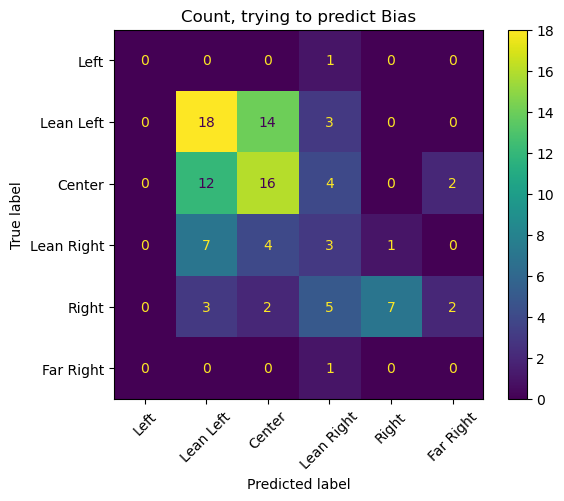

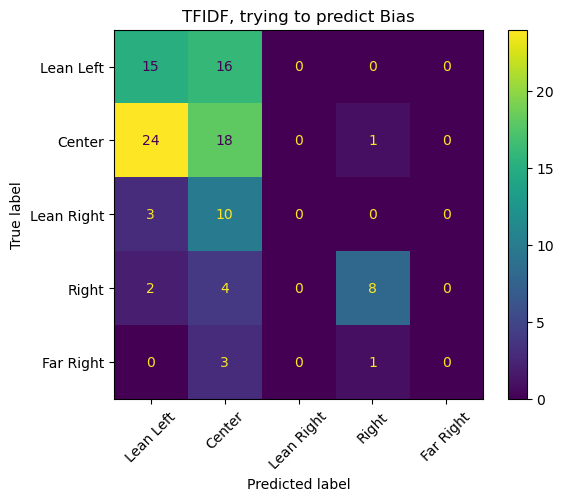

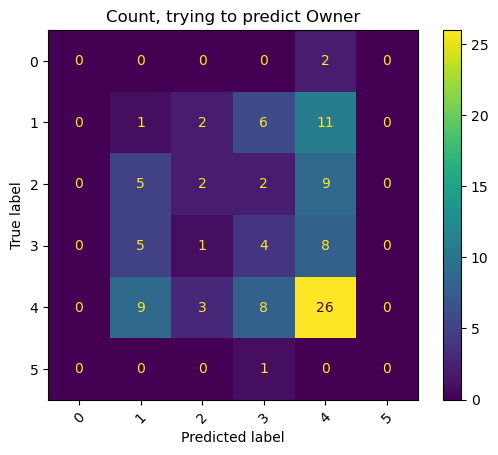

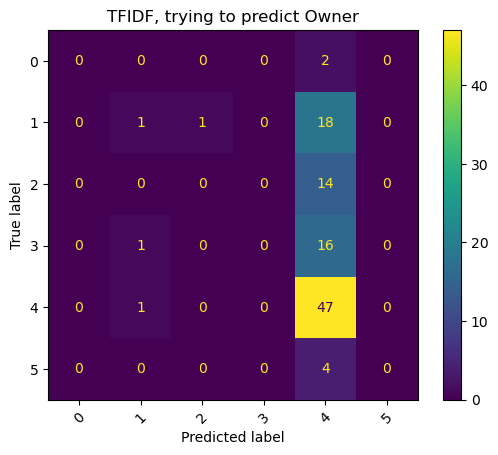

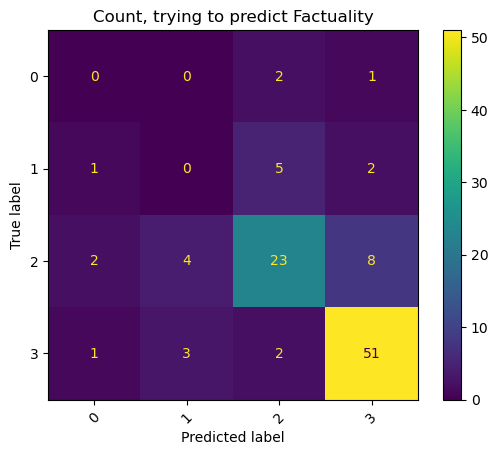

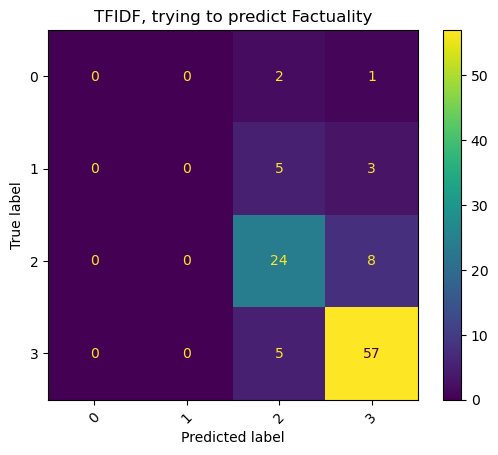

In [143]:
ConfusionMatrixDisplay(confusion_matrix = matrices[0], 
                                            display_labels = ["Left","Lean Left","Center","Lean Right","Right","Far Right"]).plot()
plt.title("Count, trying to predict Bias")
plt.xticks(rotation=45)
    
ConfusionMatrixDisplay(confusion_matrix = matrices[1], 
                                            display_labels = ["Lean Left","Center","Lean Right","Right","Far Right"]).plot()
plt.title("TFIDF, trying to predict Bias")
plt.xticks(rotation=45)

ConfusionMatrixDisplay(confusion_matrix = matrices[2]
                       #, display_labels = ['Corporation','Government','Independent','Individual','Media Conglomerate','Other','Private Equity']
                      ).plot()
plt.title("Count, trying to predict Owner")
plt.xticks(rotation=45)
    
ConfusionMatrixDisplay(confusion_matrix = matrices[3]
                       #, display_labels = ['Corporation','Government','Independent','Individual','Media Conglomerate','Other','Private Equity']
                      ).plot()
plt.title("TFIDF, trying to predict Owner")
plt.xticks(rotation=45)

ConfusionMatrixDisplay(confusion_matrix = matrices[4]
                       #, display_labels = ['High Factuality', 'Low Factuality', 'Mixed Factuality']
                      ).plot()
plt.title("Count, trying to predict Factuality")
plt.xticks(rotation=45)
    
ConfusionMatrixDisplay(confusion_matrix = matrices[5]
                       #,display_labels = ['High Factuality', 'Low Factuality', 'Mixed Factuality']
                      ).plot()
plt.title("TFIDF, trying to predict Factuality")
plt.xticks(rotation=45)